# STAT 301 Project Final Report
- By Sachleen Parmar, Justin Kim, and Calista Budi
- Project Group Number: 41

<br>

# Import & Setup

In [1]:
library(tidyverse)
library(dplyr)
library(gridExtra)
library(glmnet)
library(boot)
library(tidymodels)
library(repr)
library(patchwork)
library(MASS)
library(caret)
library(pROC)
options(repr.matrix.max.rows = 6)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

다음의 패키지를 부착합니다: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


필요한 패키지를 로딩중입니다: Matrix


다음의 패키지를 부착합니다: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-10

── Attaching packages ───────────────────────────────────────────────

<br>

# Introduction
- <MARK>TODO: need a background info of why we want to predict revenue in online shopping.<MARK>

### Scientific Question
- We want to examine whether or not a customer will produce revenue for the website can be predicted with all variables in the dataset.
- The primary goal of this question is prediction where we would like to examine the response variable `revenue` as accurate as possible with low errors on the classification test metrics.

<br>

# Data

In [2]:
# load dataset from github
data <-read_delim("https://raw.githubusercontent.com/justkwoo/stat_301_project/refs/heads/main/data/online_shoppers_intention.csv", delim = ",")

# print to inspect
head(data)

Rows: 12330 Columns: 18
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): Month, VisitorType
dbl (14): Administrative, Administrative_Duration, Informational, Informatio...
lgl  (2): Weekend, Revenue

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<lgl>,<lgl>
0,0,0,0,1,0.000000,0.20000000,0.2000000,0,0,Feb,1,1,1,1,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,64.000000,0.00000000,0.1000000,0,0,Feb,2,2,1,2,Returning_Visitor,FALSE,FALSE
0,0,0,0,1,0.000000,0.20000000,0.2000000,0,0,Feb,4,1,9,3,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,2.666667,0.05000000,0.1400000,0,0,Feb,3,2,2,4,Returning_Visitor,FALSE,FALSE
0,0,0,0,10,627.500000,0.02000000,0.0500000,0,0,Feb,3,3,1,4,Returning_Visitor,TRUE,FALSE
0,0,0,0,19,154.216667,0.01578947,0.0245614,0,0,Feb,2,2,1,3,Returning_Visitor,FALSE,FALSE


<br>

### Citation
&nbsp; Sakar, C. & Kastro, Y. (2018). Online Shoppers Purchasing Intention<br>
&nbsp; Dataset [Dataset]. UCI Machine Learning Repository.<br>
&nbsp; https://doi.org/10.24432/C5F88Q.
- This project uses this dataset under the [Creative Commons Attribution 4.0 International (CC BY 4.0) license](https://creativecommons.org/licenses/by/4.0/legalcode).

### Dataset Information
- The [Online Shoppers Purchasing Dataset](https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset) is a dataset that contains time-related information and rates acquired from user action as well as various user characteristics and background information in online shopping.
- `Administrative`, `Administrative_Duration`, `Informational`, `Informational_Duration`, `ProductRelated` and `ProductRelated_Duration` were collected from the URL information of the user's visited pages and were updated each time the user triggered an action during the session, and `BounceRates`, `ExitRates`, and `PageValues` were computed by Google Analytics for each page in the website.
- The sources or data collection methods for the remaining variables are unknown. 


### Data Description
- The number of observations in the dataset is 12330.
- The number of variables in the dataset is 18.
- **Administrative** is a non-continuous integer that represents how many pages about account management the vistor visited 
- **Administrative_Duration** is a continuous variable representing the total time in seconds spent by the visitor on adminstrative pages
- **Informational** is a non-continuous integer that represents how many pages about Website, communication, and address information management the vistor visited 
- **Information_Duration** is a continuous variable representing the total time in seconds spent by the visitor on informational pages
- **ProductRelated** is a non-continuous integer that represents how many pages about related products the vistor visited
- **ProductRelated_Duration** is a continuous variable representing the total time in seconds spent by the visitor on related product pages
- **BounceRates** is a continuous variable representing the average bounce rate value of pages the visitor visited
- **ExitRates** is a continuous variable representing the average exit rate value of the pages the visitor visited
- **PageValues** is a numerical variable representing the average page value of the pages visited
- **SpecialDay** is a number from 0 to 1 representing how close the visit to the site was to some special holiday (1 being closer to the special holiday)
- **Month** is a categorical variable corresponding with what month the visit date occurred in 
- **OperatingSystems** is a categorical variable representing what operating system the visitor is using
- **Browser** is a categorical variable representing what browser the visitor is using
- **Region** is a categorical variable representing what region the visitor is from
    - Region 1 has 4780 observations.
- **TrafficType** is a categorical variable representing how the visitor arrived on the site.
- **VisitorType** is a string representing whether a visitor has been on the website before (Returning_Visitor), have never been on the website (New_Visitor), or Other
- **Weekend** is a boolean value with TRUE representing it is the weekend and FALSE being it is not
- **Revenue** is a boolean value with TRUE representing making revenue and FALSE representing no revenue made

### Pre-selection of Variables
- Since we are also limited to only use data from `Region = 1`, we drop `Region` as it no longer provides valuable information.
- For the remaining variables, we do not drop any variables due to the contraint to use all variables in the analysis and perform variable selection based on model performance.

<br>

# EDA

### Data Wrangling

In [3]:
# filter out region 1, and convert `chr` and `lgl` dtypes to factor
tidy_data <- data %>%
        filter(Region == 1) %>%
        dplyr::select(-Region) %>%
        mutate(
               Browser = as.factor(Browser),
               OperatingSystems = as.factor(OperatingSystems),
               SpecialDay = as.factor(SpecialDay),
               TrafficType = as.factor(TrafficType),
               VisitorType = as.factor(VisitorType),
               Weekend = as.factor(Weekend)
              )
# print 
head(tidy_data)

Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,TrafficType,VisitorType,Weekend,Revenue
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<fct>,<fct>,<fct>,<fct>,<fct>,<lgl>
0,0,0,0,1,0.0000,0.20000000,0.20000000,0,0,Feb,1,1,1,Returning_Visitor,FALSE,FALSE
0,0,0,0,2,64.0000,0.00000000,0.10000000,0,0,Feb,2,2,2,Returning_Visitor,FALSE,FALSE
0,0,0,0,10,627.5000,0.02000000,0.05000000,0,0,Feb,3,3,4,Returning_Visitor,TRUE,FALSE
0,0,0,0,19,154.2167,0.01578947,0.02456140,0,0,Feb,2,2,3,Returning_Visitor,FALSE,FALSE
1,0,0,0,0,0.0000,0.20000000,0.20000000,0,0,Feb,1,2,5,Returning_Visitor,TRUE,FALSE
0,0,0,0,3,738.0000,0.00000000,0.02222222,0,0.4,Feb,2,4,2,Returning_Visitor,FALSE,FALSE


<br>

### Visualization

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”
Warning message:
“Removed 3799 rows containing non-finite outside the scale range (`stat_boxplot()`).”


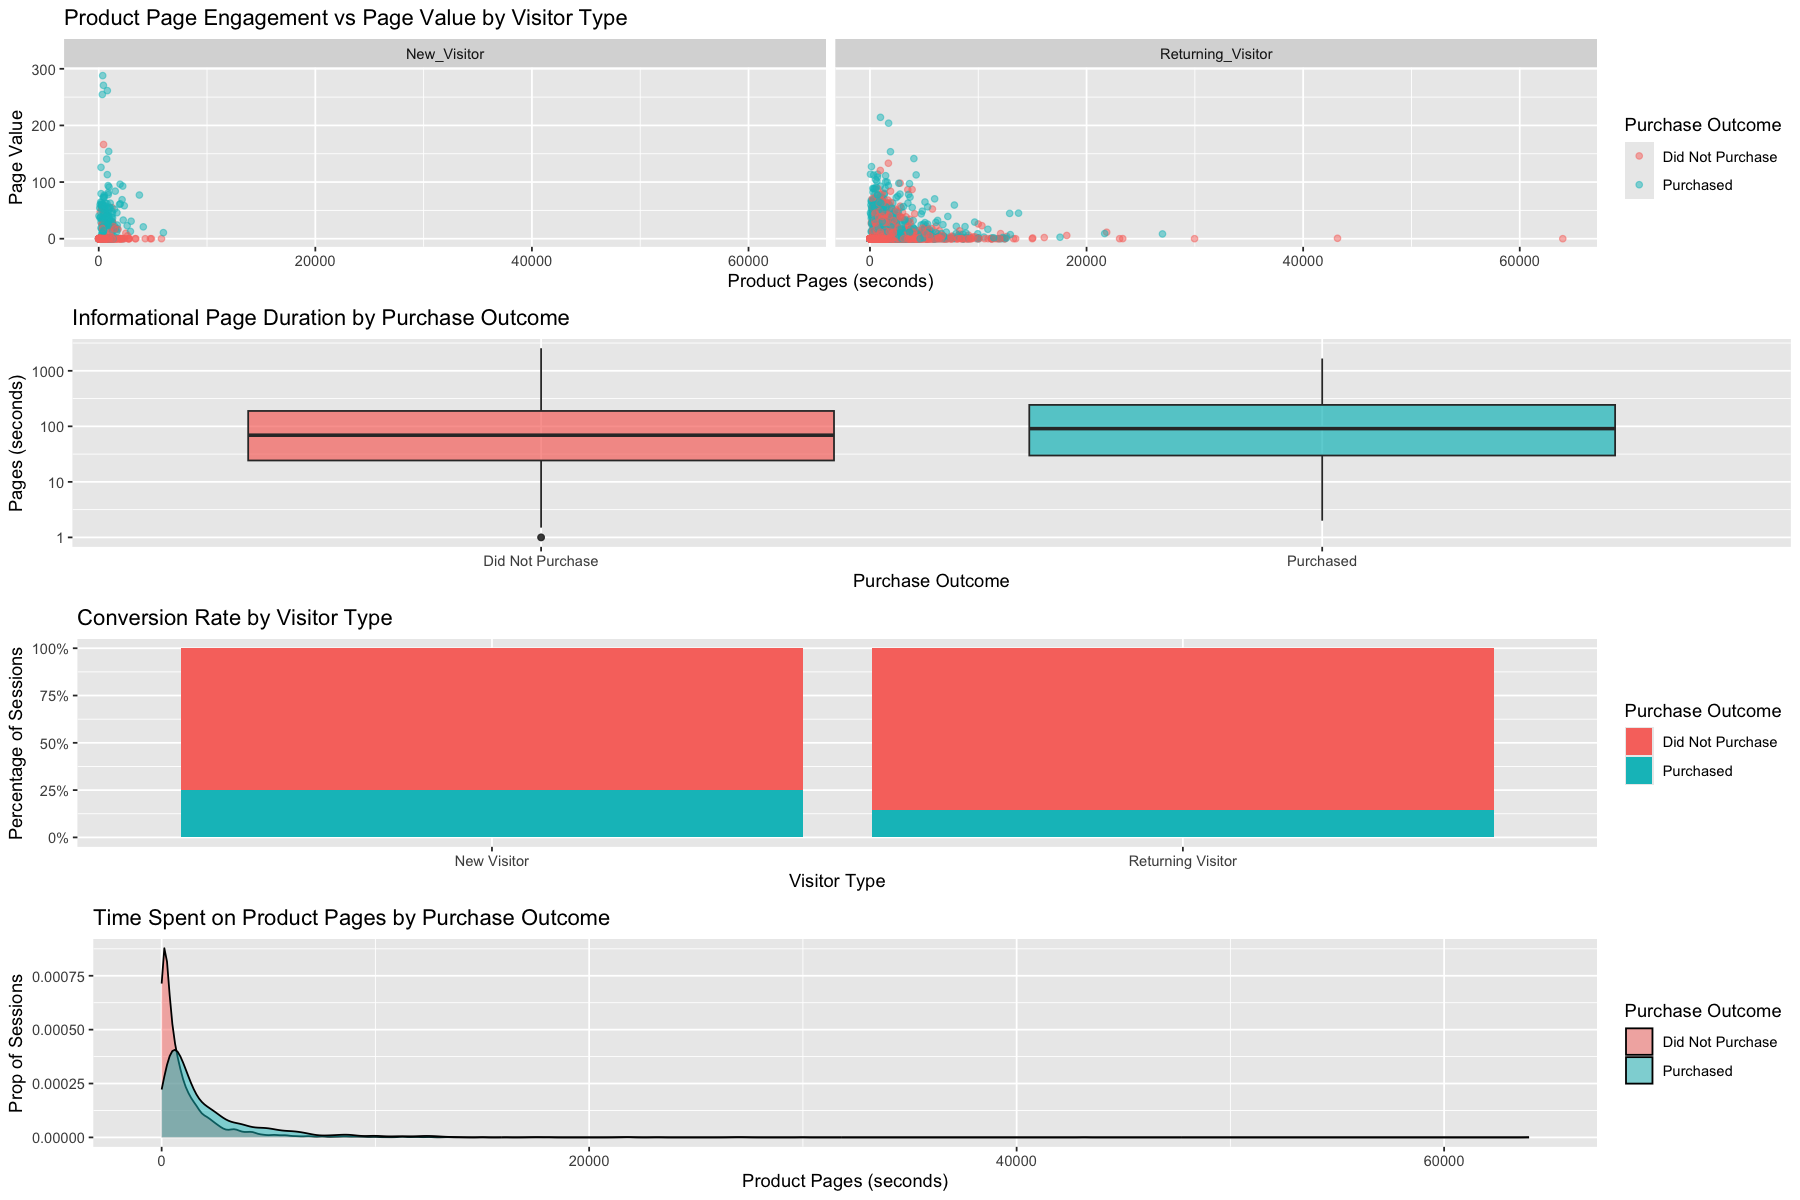

In [4]:
# Plot A: Scatter plot
filtered_data <- tidy_data |> filter(VisitorType != "Other")

plot_a <- ggplot(filtered_data, aes(x = ProductRelated_Duration,
                                   y = PageValues,
                                   color = Revenue)) +
          geom_point(alpha = 0.5) +
          facet_wrap(~ VisitorType) +
          scale_color_discrete(labels = c("FALSE" = "Did Not Purchase", "TRUE" = "Purchased")) +
          labs(title = "Product Page Engagement vs Page Value by Visitor Type",
               x = "Product Pages (seconds)",
               y = "Page Value",
               color = "Purchase Outcome")

# Plot B: Box plot
plot_b <- ggplot(filtered_data, aes(x = factor(Revenue,
                                              levels = c(FALSE, TRUE),
                                              labels = c("Did Not Purchase", "Purchased")),
                                   y = Informational_Duration,
                                   fill = Revenue)) +
          geom_boxplot(alpha = 0.7) +
          scale_y_log10() +
          labs(title = "Informational Page Duration by Purchase Outcome",
               x = "Purchase Outcome",
               y = "Pages (seconds)")  +
          theme(legend.position = "none")

#Plot C: Bar chart 
plot_c <- ggplot(filtered_data, aes(x = VisitorType, fill = Revenue)) +
          geom_bar(position = "fill") +
          scale_y_continuous(labels = scales::percent_format(accuracy = 1)) +
          scale_x_discrete(labels = c("New_Visitor" = "New Visitor", "Returning_Visitor" = "Returning Visitor")) +
          scale_fill_discrete(labels = c("FALSE" = "Did Not Purchase", "TRUE" = "Purchased")) +
          labs(title = "Conversion Rate by Visitor Type",
               x = "Visitor Type",
               y = "Percentage of Sessions",
               fill = "Purchase Outcome")

#Plot D: Density Plot
plot_d <- ggplot(filtered_data, aes(x = ProductRelated_Duration, fill = Revenue)) +
          geom_density(alpha = 0.5) +
          scale_fill_discrete(labels = c("FALSE" = "Did Not Purchase", "TRUE" = "Purchased")) +
          labs(title = "Time Spent on Product Pages by Purchase Outcome",
               x = "Product Pages (seconds)",
               y = "Prop of Sessions",
               fill = "Purchase Outcome") 

# print plots
options(repr.plot.width=15, repr.plot.height=10)
grid.arrange(plot_a, plot_b, plot_c, plot_d, nrow = 4)

### Interpretations 

#### Interpretation for Plot A - Scatter Plot
- The scatterplot explores whether time spent on product pages relates to page value and whether this pattern differs by visitor type.
- Across both groups, most sessions cluster at low engagement and low page value, but purchased sessions show noticeably higher page values as compared to non-purchased ones.
- Overall, the plot suggests that purchase outcome, not visitor type, is the main driver of higher page value, and that product-page duration alone shows a weak relationship with value. 

#### Interpretation for Plot B - Box Plot
- The bar plot helps assess whether viewing informational pages is related to purchasing behavior.
- Purchasers generally spend slightly more time on informational pages compared to non-purchasers, although the time spent is heavily skewed with many short interactions.
- This indicates that informational content may play a role in supporting conversions, but low engagement levels could be a limitation to investigate further.

#### Interpretation for Plot C - Bar Chart
- The bar chart is relevant for identifying whether visitor type influences conversion likelihood.
- Returning visitors show a modestly higher conversion rate compared to new visitors, although the majority of both groups do not purchase.
- This suggests visitor type could be a relevant feature in modeling purchase outcomes, with returning visitors showing stronger purchase intent.

#### Interpretation for Plot D - Density Plot
- The density plot examines whether time spent on product pages differs between purchasers and non-purchasers.
- Both groups show very low time spent on product pages, but purchasers display a slightly longer right-tail, meaning some spend more time compared to non-purchasers.
- This suggests that while product engagement is generally low, higher time spent may still signal stronger purchase intent.

<br>

# Method and Plan

### Proposed Method
- We will use LASSO and Logistic Regression as the models for revenue prediction.
- For Logistic Regression, we will use `stepAIC` backward selection method using all the covariates to retrieve the best model.
- We will use classification metrics to evaluate the perfomence on the test set.

### Why is this method appropriate?:
- The question I address here is a classification problem to predict whether the revenue would happen or not, and thus logistic regression, a classficiation method, is an appropriate choice. Also, logistic regression will ensure the values stay between the required range of 0 and 1. 
- The backward selection method begins with the full set of predictors and iteratively removes variables to retain only the most relevant predictors. Therefore, bacwkard model selection helps achieving the effective predictor set. Here, we use `stepAIC` instead of `regsubsets` as we aim to include all dummy variables associated with the categorical predictors.
- Since this is a classificaiton task, classification metrics allow to evaluate the prediction performance. 
- LASSO is commonly used for predictions as it is a less greedy algorithm than backwards selection.
- Using LASSO and Logistic Regression allow us to compare and contrast whether LASSO or Logistic Regression with Backward Selection does a better job predicting the revenue.

### Required Assumptions:
- To apply logistic regression, the response variable `revenue` must be a binary variable, and it must be stored as a `factor` in R.
- Logistic regression also assumes that there exists a linear relationship between the log-odds of the response variable and the predictors.
- Moreover, it assumes the response follows a Bernoulli random variable, thus its variance should be around $p(1-p)$, where $p$ is the probability of getting revenue.
- Lastly, observations are assumed to be independent, such that each data point doesn't influence each other.

### Potential Limitations/Weaknesses:
- Since logistic regression assumes a linear relationship between the log-odds of the response variable and the predictors, it might underperform when the true relationship is weakly linear or non-linear.
- Moreover, since logistic regression is a very simple model compared to other classificaiton methods such as random forests or neural networks, the performance might not be good enough compared to models with higher complexity.
- Typically the variance might not act like a Bernoulli random variable, and thus will lead to a bad prediction; we can use an overdispersion parameter such as the one given in quasibinomial to fix this.

### Model Assessment Plan
- We will first report and evaluate classificaiton performance of each indiivdual model.
  - The classification metrics we use here are accuracy, recall, precision.
  - Accuracy will be used to evaluate the overall performance, recall will be used to evaluate how many of the true positives the model successfully identified, and precision to evalaute how many of the predicted positives are actually positive. 
- Then, based on these results, we will compare the two models and discuss which one performs better.

<br>

# Computational Code and Output

### Data Split

In [5]:
# set seed for reproducibility
set.seed(1)

# split data with 70/30 ratio
split_data <- tidy_data %>%
    initial_split(prop = 0.7, strata = Revenue)

# define training and test dataset
train_set <- training(split_data)
test_set <- testing(split_data)

<br>

### Logistic Regression

In [6]:
# define full model
full_model <- glm(Revenue ~ ., 
                  family = binomial, 
                  data = train_set)

# perform backward selection using stepAIC function 
best_model <- stepAIC(full_model, direction = "backward")

Start:  AIC=1993.52
Revenue ~ Administrative + Administrative_Duration + Informational + 
    Informational_Duration + ProductRelated + ProductRelated_Duration + 
    BounceRates + ExitRates + PageValues + SpecialDay + Month + 
    OperatingSystems + Browser + TrafficType + VisitorType + 
    Weekend

                          Df Deviance    AIC
- OperatingSystems         6   1873.1 1983.1
- SpecialDay               5   1877.9 1989.9
- Browser                  9   1887.0 1991.0
- ProductRelated           1   1871.7 1991.7
- Administrative_Duration  1   1871.8 1991.8
- BounceRates              1   1871.8 1991.8
- Informational_Duration   1   1872.1 1992.1
- Informational            1   1872.2 1992.2
- Weekend                  1   1872.4 1992.4
- VisitorType              2   1874.6 1992.6
- Administrative           1   1872.8 1992.8
- TrafficType             18   1907.4 1993.4
<none>                         1871.5 1993.5
- ProductRelated_Duration  1   1874.8 1994.8
- ExitRates           

<br>

In [7]:
formula(best_model)

Revenue ~ ProductRelated_Duration + ExitRates + PageValues + 
    Month + TrafficType

<br>

In [8]:
# compute predicted probabiltiies for test set
pred_probs <- predict(best_model, test_set, type = "response")

# compute binary classes using the above probabilities
pred_labels <- ifelse(pred_probs >= 0.5, TRUE, FALSE)

# calculate true positives, true negatives, false positives, false negatives
TP <- sum(pred_labels == "TRUE" & test_set$Revenue == "TRUE")
TN <- sum(pred_labels == "FALSE"& test_set$Revenue == "FALSE")
FP <- sum(pred_labels == "TRUE" & test_set$Revenue == "FALSE")
FN <- sum(pred_labels == "FALSE" & test_set$Revenue == "TRUE")

# compute accuracy, precision, recall
accuracy <- (TP + TN) / (TP + TN + FP + FN)
precision <- TP / (TP + FP)
recall <- TP / (TP + FN)

# make a table containing all test metrics
classification_metrics <- data.frame(
    Metric = c("Accuracy", "Precision", "Recall"),
    Score = c(accuracy, precision, recall)
)

# plot a table
classification_metrics

Metric,Score
<chr>,<dbl>
Accuracy,0.8724739
Precision,0.6899225
Recall,0.3836207


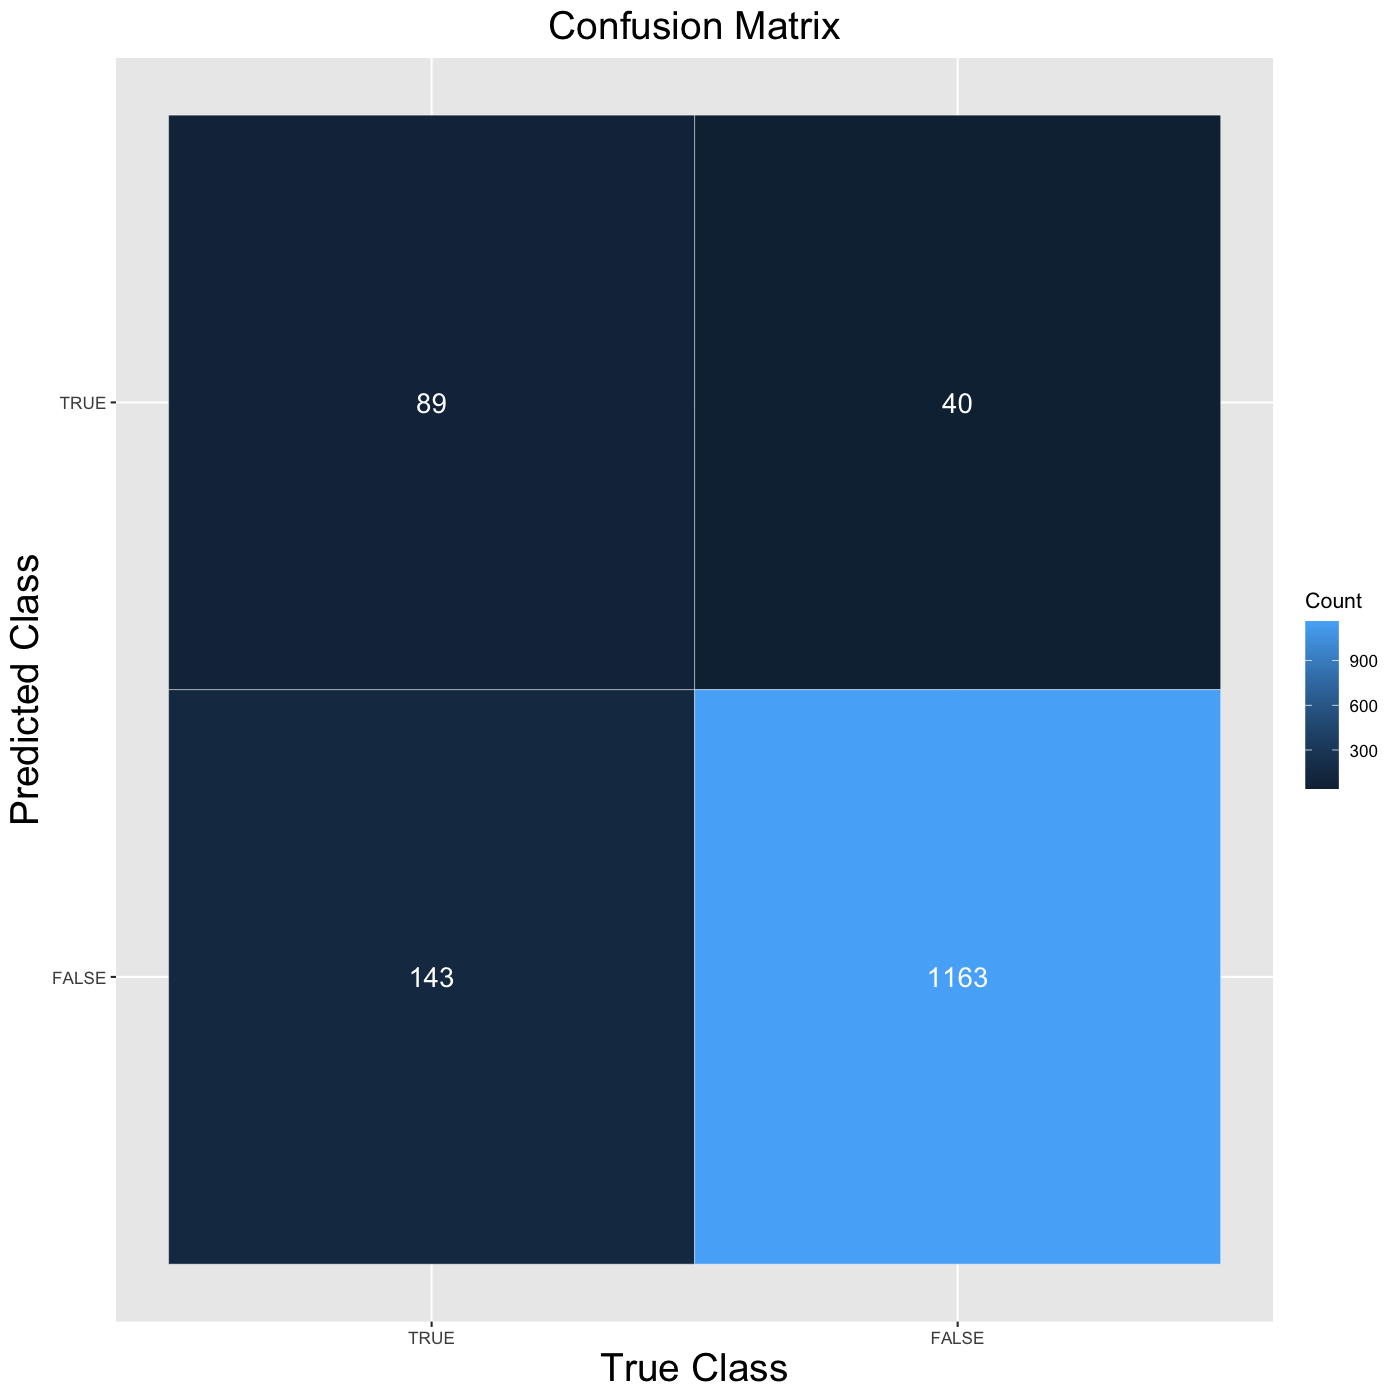

In [9]:
# make a confusion matrix table for visualization
conf_mat_table <- data.frame(
    True = rep(c("TRUE", "FALSE"), each = 2),
    Pred = rep(c("TRUE", "FALSE"), times = 2),
    Count = c(TP, FN, FP, TN)
)

# size the plot
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 140)

# define confusion matrix plot object
conf_mat <- ggplot(conf_mat_table, aes(x = factor(True, levels = c("TRUE", "FALSE")), y = Pred, fill = Count)) +
    geom_tile(color = "white") +
    geom_text(aes(label = Count), color = "white", size = 5) +
    labs(x = "True Class", y = "Predicted Class", title = "Confusion Matrix") +
    theme(plot.title = element_text(size = 20, hjust = 0.5),
          axis.title = element_text(size = 20))

# plot confusion matrix
conf_mat

<br>

### LASSO

In [10]:
# change `Revenue` dtype in both train and test set to numeric to apply LASSO
train_set <- train_set %>%
    mutate(Revenue = as.numeric(Revenue))

test_set <- test_set %>%
    mutate(Revenue = as.numeric(Revenue))

# separate predictors and labels
training_x <- model.matrix(~ . - 1, data = train_set[, -17])
training_y <- as.matrix(train_set[,17])
testing_x <- model.matrix(~ . - 1, data = test_set[, -17])
testing_y <- as.matrix(test_set[,17])

In [11]:
# define LASSO model
lasso_model <- 
  cv.glmnet(
      x = training_x,
      y = training_y,
       alpha = 1,
       family = "binomial",
      type.measure = "auc",
       nfolds = 10)

lasso_model


Call:  cv.glmnet(x = training_x, y = training_y, type.measure = "auc",      nfolds = 10, alpha = 1, family = "binomial") 

Measure: AUC 

     Lambda Index Measure       SE Nonzero
min 0.04226    17  0.9014 0.007208       4
1se 0.05587    14  0.8984 0.007263       3

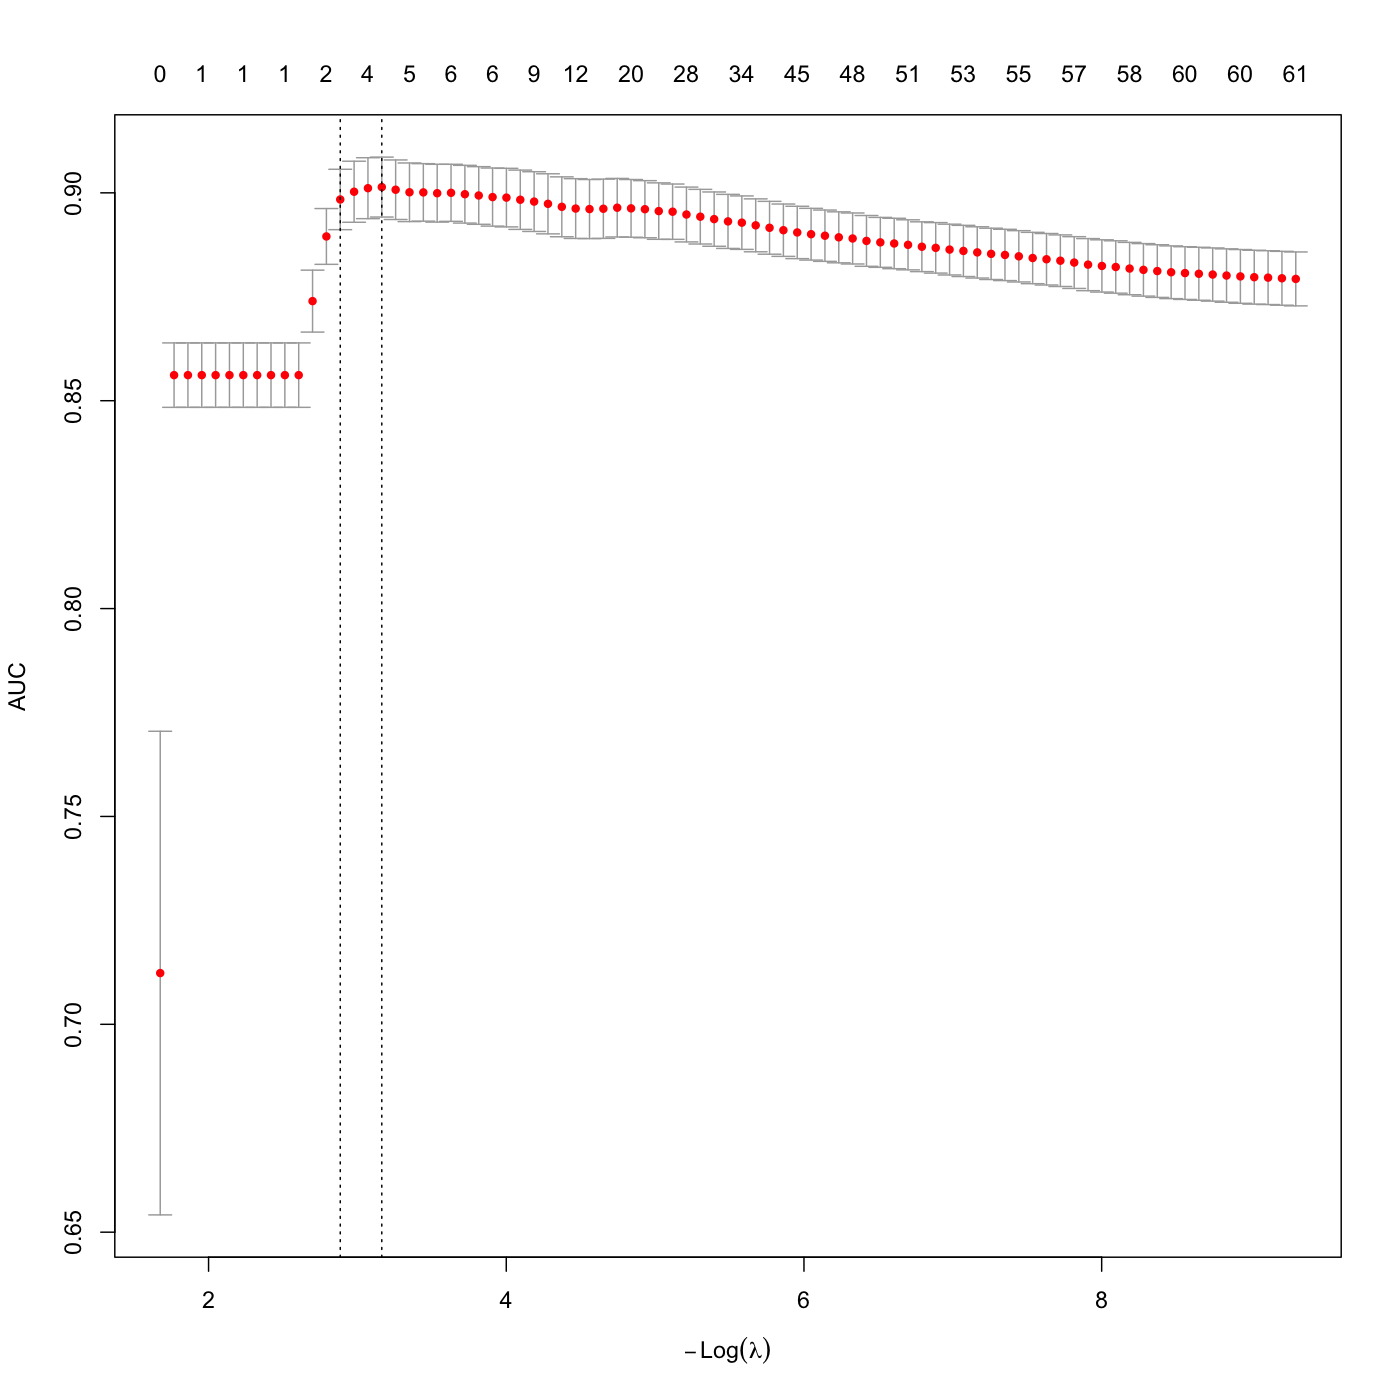

In [12]:
# draw cv curve across different params
plot(lasso_model)

In [13]:
# retrieve chosen parameter
lambda_1se <- lasso_model$lambda.1se

lambda_1se

[1] 0.05587088

In [14]:
# define LASSO with the chosen param
main_lasso <- glmnet(
    x = training_x,
    y = training_y,
    alpha = 1,
    family = "binomial",
    lambda = lambda_1se
)

# print coefs
coef(main_lasso)

63 x 1 sparse Matrix of class "dgCMatrix"
                                        s0
(Intercept)                  -2.0837167410
Administrative                .           
Administrative_Duration       .           
Informational                 .           
Informational_Duration        .           
ProductRelated                0.0009244207
ProductRelated_Duration       .           
BounceRates                   .           
ExitRates                     .           
PageValues                    0.0452428223
SpecialDay0                   .           
SpecialDay0.2                 .           
SpecialDay0.4                 .           
SpecialDay0.6                 .           
SpecialDay0.8                 .           
SpecialDay1                   .           
MonthDec                      .           
MonthFeb                      .           
MonthJul                      .           
MonthJune                     .           
MonthMar                      .           
MonthMay    

In [15]:
# predict on the test set
prediction <- predict(main_lasso,
                      newx = testing_x,
                      type = "response")

predict_labels <- ifelse(prediction >= 0.5, 1, 0)

# print conf mat
confusion_matrix <- 
    confusionMatrix(
    data = as.factor(predict_labels),
    reference = as.factor(test_set$Revenue),
    positive = "1"
) 

confusion_matrix

Confusion Matrix and Statistics

          Reference
Prediction    0    1
         0 1189  188
         1   14   44
                                          
               Accuracy : 0.8592          
                 95% CI : (0.8402, 0.8768)
    No Information Rate : 0.8383          
    P-Value [Acc > NIR] : 0.01596         
                                          
                  Kappa : 0.2553          
                                          
 Mcnemar's Test P-Value : < 2e-16         
                                          
            Sensitivity : 0.18966         
            Specificity : 0.98836         
         Pos Pred Value : 0.75862         
         Neg Pred Value : 0.86347         
             Prevalence : 0.16167         
         Detection Rate : 0.03066         
   Detection Prevalence : 0.04042         
      Balanced Accuracy : 0.58901         
                                          
       'Positive' Class : 1               
                        

Setting levels: control = 0, case = 1

Warning message in roc.default(response = test_set$Revenue, predictor = predict(main_lasso, :
“Deprecated use a matrix as predictor. Unexpected results may be produced, please pass a numeric vector.”
Setting direction: controls < cases



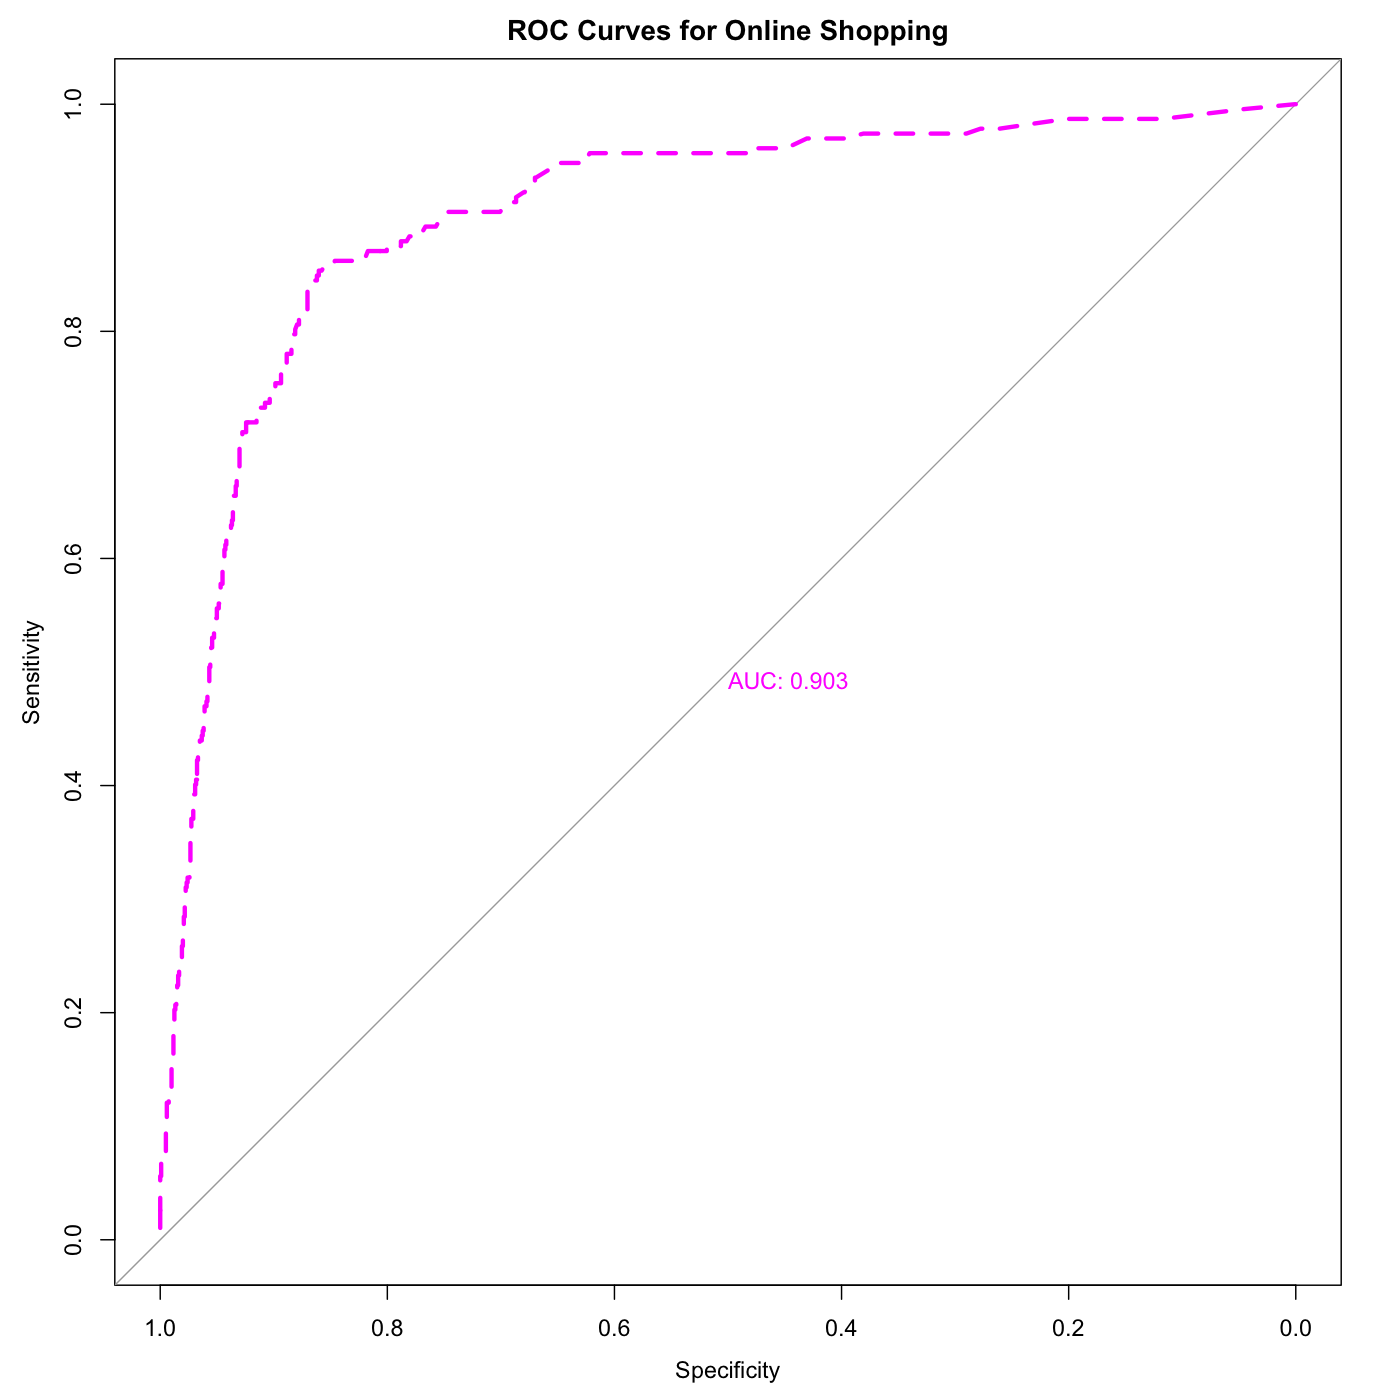

In [16]:
# draw ROC curve
ROC_full_log <- roc(
  response = test_set$Revenue,
  predictor = predict(main_lasso, newx = testing_x, type = "response")
)

plot(ROC_full_log,
  print.auc = TRUE, col = "magenta", lwd = 3, lty = 2,
  main = "ROC Curves for Online Shopping"
)

<br>

# Discussion

### Logistic Regression Model
- The final selected model from the backward selection is `Revenue ~ ProductRelated_Duration + ExitRates + PageValues + Month + TrafficType`.
- The model can correctly classify most test samples with a high accuracy of ~87.2%, which indicates a fairly strong overall performance in classifying revenue and non-revenue cases.
- However, for the true revenue class, the model exhibits a significant degree of misclassification with a recall of ~38.4% and 143 false negatives, indicating a large proportion of actual revenue cases are not correctly distinguished.
- Moreover, with a precision of ~69% and 40 false positives, there also exists a moderate degree of error of having false positives in its positive case predictions. This implies that around 31% of its predicted revenue cases ara actually non-revenue cases.

### LASSO Model
- The selected model by LASSO is `Revenue ~ ProducteRelated + PageValues + MonthNov`.
- From the confusion matrix, one can see that the accuracy is ~85.9%. This indicates that the model has a fairly good performance and that we can answer our question of predicting revenue using the variables from the dataset.
- The ROC Curve gave us an AUC of 0.903. This indicates that the model does a good job of differentiating between the classes of gaining revenue and not gaining revenue.
- With a precision of ~75.9% and 14 false positives, around ~75.9% of its positive predictions are correct. However, a recall of ~19% suggests that the model only detects ~19% of the true positive cases. This suggests that while a good proportion of the model's positive predictions are correct revenue cases, it exhibits a signficant error in detecting actual revenue cases.
- Also, the issue with LASSO is that it can't deal with collinear variables. Therefore, if there is multicollinearity, using LASSO wouldn't give us any idea about that.

### Model Comparison
- The Logistic Regression achieves a slightly higher accuracy of ~87.2% compared to LASSO with a accuracy of ~85.9%.
- Moreover, Logistic Regression performs better at detecting true revenue cases with a recall of ~38.4%, while LASSO has a lower recall of ~19%.
- Altough their precision scores are similar, LASSO has a slightly better precision of ~75.9% compared to Logistic Regresssion with a precision of ~69%. This indicates that LASSO perform better in its positive predictions, meaninig a greater proportion of its predicted revenue cases are actually true revenue cases.
- In conclusion, both model have similar scores for accuracy and precision, but Logistic Regression has a much higher recall compared to LASSO. In cases where missing actual revenue is costly and minimizing false negatives is crucial, Logistic Regression would be preferred over LASSO due to its higher recall.
- However, for a better performance in recall and preicison, this still raises a need to explore different methods to reduce both false positive and false negatives.

### Discuss future questions/research this study could lead to
- Our study provides an initial framework to predicting whether an online customer completes a purchase through the website, and these findings point toward several meaningful directions for future shopping behaviour research.
Since variables such as PageValues, ExitRates, and ProductRelated_Duration consistently emerged as influential predictors across both logistic regression and LASSO, we could explore more on why these features carry more predictive power and what specific user behaviors initiate them. Understanding this could help identify more targeted website changes to support conversion rates, for instance improving high-exit pages or value of key product pages. 
- Another direction would be to check whether these predictors behave the same way in other regions or during different times of the year, especially because our analysis only used Region 1. This would show whether the patterns we found are general trends or specific to a particular user group. Exploring these differences could help businesses understand how consumer behavior changes across locations or seasons, and whether different audiences respond differently to website features.
- Overall, our research shows that online purchases can be reasonably predicted using key session features, and future work could explore why these features matter, as well as whether these patterns remain consistent across different user groups and conditions.